In [5]:
## imports

import os
import matplotlib
from pathlib import Path

import glob
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
import napari
import gunpowder as gp

### Load data

In [6]:
base_path = Path("/mnt/shared/celltracking/data/cho/")
#base_path = Path("/mnt/shared/celltracking/data/celegans/")
img = np.stack([imread(xi) for xi in sorted((base_path / "01").glob("*.tif"))])  # images
seg = np.stack([imread(xi) for xi in sorted((base_path / "01_ST/SEG").glob("*.tif"))])  # images
tra = np.stack([imread(xi) for xi in sorted((base_path / "01_GT/TRA").glob("*.tif"))])  # images

### Have a look at data structure

In [7]:
print(f'img:{img.shape}')
print(f'seg:{seg.shape}')
print(f'tra:{tra.shape}')

img:(92, 5, 443, 512)
seg:(92, 5, 443, 512)
tra:(92, 5, 443, 512)


### View imported data with napari

In [18]:
viewer = napari.Viewer()
viewer.add_image(img, name="image");
viewer.add_image(tra,name='tra');
viewer.add_image(seg,name='seg');

/home/yserentantk/miniconda3/envs/exercise08_v2/lib/python3.9/site-packages/napari/_qt/__init__.py:53: UserWarning: 

napari was tested with QT library `>=5.12.3`.
The version installed is 5.9.7. Please report any issues with
this specific QT version at https://github.com/Napari/napari/issues.
  warn(message=warn_message)


### View flatened images

In [9]:
img_flat = img.sum(axis=1)
tra_flat = tra.sum(axis=1)
img_flat.shape
viewer.add_image(img_flat, name="image_flat");
viewer.add_image(tra_flat,name='tra_flat');


### Look at subvolumes extracted with gunpowder

batch returned: 
	raw: ROI: [0:1, 0:5, 97:161, 192:256] (1, 5, 64, 64), voxel size: (1, 1, 1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False



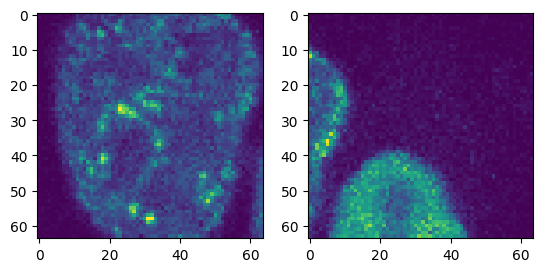

In [26]:
# provide path to zarr directory
zarrdir = '/mnt/shared/celltracking/data/cho/01.zarr'

# pre-selected volumes from cho dataset
coord_paired = ((0,0,80, 175),(1,0,80, 180))
coord_unpaired = ((0,0,80, 175),(1,0,92, 232))

# specify subvolume size and volume source
volSize = (1,5,64, 64)
coord = coord_paired[0]

# declare arrays to use in the pipeline
key ='raw'
raw = gp.ArrayKey(key)

# create "pipeline" consisting only of a data source
source = gp.ZarrSource(
    zarrdir,  # the zarr container
    {raw: key},  # which dataset to associate to the array key
    {raw: gp.ArraySpec(interpolatable=True)}  # meta-information
)
pipeline = gp.Pipeline(source)

# specify request 
request_vol1 = gp.BatchRequest()
request_vol2 = gp.BatchRequest()
request_vol1[raw] = gp.Roi(coord_unpaired[0], volSize)
request_vol2[raw] = gp.Roi(coord_unpaired[1], volSize)

# build the pipeline
with gp.build(pipeline):
    batch_vol1 = pipeline.request_batch(request_vol1)
    batch_vol2 = pipeline.request_batch(request_vol2)
    
# show the content of the batch
print(f"batch returned: {batch}")

# plot first slice of volume

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.flipud(batch_vol1[raw].data[0,1,:,:]))
ax2.imshow(np.flipud(batch_vol2[raw].data[0,1,:,:]))

# load volume into napari
# viewer = napari.Viewer()
# viewer.add_image(batch[raw].data, name="volume 1");